# ST000369
This data is available at the NIH Common Fund's National Metabolomics Data Repository (NMDR) website, the Metabolomics Workbench, https://www.metabolomicsworkbench.org where it has been assigned Project ID (PR000293). The data can be accessed directly via it's Project DOI: (10.21228/M85P57). This work is supported by Metabolomics Workbench/National Metabolomics Data Repository (NMDR) (grant# U2C-DK119886), Common Fund Data Ecosystem (CFDE) (grant# 3OT2OD030544) and Metabolomics Consortium Coordinating Center (M3C) (grant# 1U2C-DK119889).

### AdaBoost Classifier
Questo dataset, basato su spettrometria di massa a gas-cromatografia (GC-MS), contiene 181 metaboliti identificati nel siero e nel plasma. In questa analisi confrontiamo il gruppo di pazienti con adenocarcinoma polmonare (Classe=1) con il gruppo di controllo sano (Classe=0).

### 1. Import Packages

In [2]:
# Librerie di base
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Librerie per la Data Imputation
from sklearn.impute import KNNImputer

# Librerie per i test di significatività statistica
import scipy.stats as stats

# Librerie per il Machine Learning
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_val_predict

# Librerie per la Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV

# Librerie per la Features Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Librerie per la PCA
from sklearn.decomposition import PCA

# Librerie per la curva ROC
from sklearn.metrics import roc_curve, auc

print('All packages successfully loaded')

All packages successfully loaded


### 2. Load Data & Peak Sheet

In [3]:
df = pd.read_excel('../../../data/ST000369.xlsx')

# Rimuoviamo le colonne che non ci servono
df.drop(columns=["Idx", "SampleID", "Class"], inplace=True)

# Visualizziamo le prime 5 righe del dataset
df.head()

,SampleType,HealthState,SmokingStatus,Sex,M1,M2,M3,M4,M5,M6,...,M172,M173,M174,M175,M176,M177,M178,M179,M180,M181
0,Plasma,Adenocarcinoma,Former,F,194,168,77,105985,118,15489,...,195,1606,300,108,7203,43,59,1009,383,68
1,Plasma,Adenocarcinoma,Former,F,215,143,154,100462,133,13534,...,184,364,1364,160,11910,82,99,136,1021,165
2,Plasma,Adenocarcinoma,Current,F,104,67,45,75301,94,7390,...,189,157,884,73,6372,59,35,115,530,72
3,Plasma,Adenocarcinoma,Current,M,360,642,82,42097,84,50943,...,320,1621,461,104,14011,69,86,845,1309,127
4,Plasma,Adenocarcinoma,Current,M,96,137,95,112346,168,41987,...,84,769,266,158,18140,40,87,1213,1037,149


### 2.1 Data Cleaning

Per quanto riguarda il data cleaning del dataset, sono necessarie due tipologie di operazioni sui dati: 
1. Alcuni valori della feature "*HealthState*" sono scritti incorrettamente, perciò dobbiamo effettuarne la correzione.
2. Tre features binarie sono espresse attraverso stringhe e non valori binari (0 e 1), perciò dobbiamo fare la sostituzione.

In [4]:
# Effettuiamo la correzione dei valori errati
df["HealthState"] = df["HealthState"].str.replace('Adenocarcnoma', 'Adenocarcinoma')
df["HealthState"] = df["HealthState"].str.replace('Adenosquamous', 'Adenocarcinoma')

# Eliminiamo le righe con valori nulli all'interno delle colonne "HealthState" e "Sex"
df = df.dropna(subset=["HealthState", "Sex"])

# Convertiamo i valori di natura categorica in valori numerici
df['Output'] = df['HealthState'].apply(lambda x: 1 if x in ['Adenosquamous', 'Adenocarcinoma'] else 0)
df['SmokingStatus'] = df['SmokingStatus'].apply(lambda x: 1 if x in ['Current'] else 0)
df['Sex'] = df['Sex'].apply(lambda x: 1 if x in ['F'] else 0)

# Visualizziamo le prime 5 righe del dataset
df.head()

,SampleType,HealthState,SmokingStatus,Sex,M1,M2,M3,M4,M5,M6,...,M173,M174,M175,M176,M177,M178,M179,M180,M181,Output
0,Plasma,Adenocarcinoma,0,1,194,168,77,105985,118,15489,...,1606,300,108,7203,43,59,1009,383,68,1
1,Plasma,Adenocarcinoma,0,1,215,143,154,100462,133,13534,...,364,1364,160,11910,82,99,136,1021,165,1
2,Plasma,Adenocarcinoma,1,1,104,67,45,75301,94,7390,...,157,884,73,6372,59,35,115,530,72,1
3,Plasma,Adenocarcinoma,1,0,360,642,82,42097,84,50943,...,1621,461,104,14011,69,86,845,1309,127,1
4,Plasma,Adenocarcinoma,1,0,96,137,95,112346,168,41987,...,769,266,158,18140,40,87,1213,1037,149,1


/Users/nova/Programming/anaconda3/envs/thesis/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/nova/Programming/anaconda3/envs/thesis/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)


Text(0.5, 0.98, 'Distribuzione dei metaboliti per stato di salute')

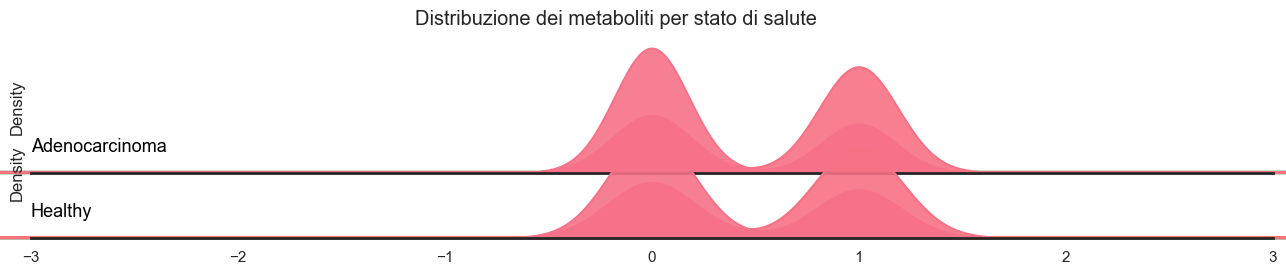

In [5]:
# Theme

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth': 2})
g = sns.FacetGrid(df, row="HealthState", hue="HealthState", aspect=9, height=1.5)

# map df to plot, color group by phenotypes
g.map_dataframe(sns.kdeplot, fill=True, linewidth=1.5, alpha=.9,  clip_on=False)


# function to draw labels
def label(x, color, label):
    ax = plt.gca()  #get current axis
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)


# iterate grid to plot labels
g.map(label, "HealthState")

# adjust subplots to create overlap
g.fig.subplots_adjust(hspace=-.5)

#viewport beetwen 0 and 1
g.set(xlim=(-3, 3))


# remove subplot titles
g.set_titles("")

# remove yticks and set xlabel
g.set(yticks=[], xlabel="")
# remove left spine
g.despine(left=True)
# set title
plt.suptitle('Distribuzione dei metaboliti per stato di salute', y=0.98)

### 3. Extract X & Y

In [6]:
X = df.drop(columns=['SampleType', 'HealthState', 'Output'])
X_features_names = X.columns
y = df.Output

### 3.1 Data Imputation

In [7]:
# KNNImputer
imputer_knn = KNNImputer()
imputer_knn.fit(X)
X[:] = imputer_knn.fit_transform(X)
X_knn = X.copy()

/var/folders/dv/cqkd8q211lb6w_8jd__s86d40000gn/T/ipykernel_2760/4178831705.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X[:] = imputer_knn.fit_transform(X)


### 3.2 Train-test Split

In [8]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y, test_size=0.2, random_state=42)

### 4. Initial Model Build

In [9]:
# Definiamo il modello AdaBoost Classifier con gli iperparametri di default
model = AdaBoostClassifier()

# Addestriamo il modello
model.fit(X_train_knn, y_train_knn)

# Eseguiamo le previsioni sui dati di test
y_pred_knn = model.predict(X_test_knn)

### 5. Initial Model Evalutation

In [10]:
# Valutiamo le metriche con gli iperparametri di default
accuracy_knn = metrics.accuracy_score(y_test_knn, y_pred_knn)
precision_knn = metrics.precision_score(y_test_knn, y_pred_knn)
recall_knn = metrics.recall_score(y_test_knn, y_pred_knn)
f1_knn = metrics.f1_score(y_test_knn, y_pred_knn)
roc_auc_knn = metrics.roc_auc_score(y_test_knn, y_pred_knn)

# Stampiamo le metriche
print(f'Accuratezza: {accuracy_knn}')
print(f'Precision: {precision_knn}')
print(f'Recall: {recall_knn}')
print(f'F1-score: {f1_knn}')
print(f'ROC AUC: {roc_auc_knn}')

Accuratezza: 0.6666666666666666
Precision: 0.65
Recall: 0.7647058823529411
F1-score: 0.7027027027027027
ROC AUC: 0.6636029411764706


Abbiamo un'accuratezza di 66%, una Precision di 65% e una Recall di 76%. Proviamo con la K-Fold Cross Validation.

In [11]:
# Creiamo l'oggetto K-Fold per la Cross Validation con il numero di fold ottimale
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

### 6. Hyperparameters Optimization

L'**ottimizzazione degli iperparametri** è un passo fondamentale nello sviluppo di modelli predittivi robusti. Infatti, aderire ai parametri predefiniti impedisce ai modelli di raggiungere il massimo delle prestazioni. A tale scopo, utilizziamo la tecnica **Grid Search**.

In [12]:
# Creiamo un nuovo modello
model_2 = AdaBoostClassifier()

# Definiamo la griglia con i parametri da testare
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300],           
    'learning_rate': [0.01, 0.1, 1.0, 10],        
    'estimator': [None, DecisionTreeClassifier(max_depth=1)],
    'algorithm': ['SAMME', 'SAMME.R'],    
    'random_state': [42]
}

# Grid Search
grid_search = GridSearchCV(model_2, param_grid, scoring='accuracy', cv=kfolds, n_jobs=-1)
grid_search.fit(X_knn, y)

# Visualizziamo i risultati
best_params = grid_search.best_params_
print("Iperparametri migliori:", best_params)

Iperparametri migliori: {'algorithm': 'SAMME.R', 'estimator': None, 'learning_rate': 1.0, 'n_estimators': 300, 'random_state': 42}


In [13]:
# Utilizziamo gli iperparametri ottimizzati per creare un nuovo modello
best_model = AdaBoostClassifier(**best_params)
best_model.fit(X_train_knn, y_train_knn)
y_pred_knn = best_model.predict(X_test_knn)

In [14]:
# Valutiamo le prestazioni del modello con gli iperparametri di default
accuracy_knn = metrics.accuracy_score(y_test_knn, y_pred_knn)
precision_knn = metrics.precision_score(y_test_knn, y_pred_knn)
recall_knn = metrics.recall_score(y_test_knn, y_pred_knn)
f1_knn = metrics.f1_score(y_test_knn, y_pred_knn)
roc_auc_knn = metrics.roc_auc_score(y_test_knn, y_pred_knn)

print(f'Accuratezza: {accuracy_knn}')
print(f'Precision: {precision_knn}')
print(f'Recall: {recall_knn}')
print(f'F1-score: {f1_knn}')
print(f'ROC AUC: {roc_auc_knn}')

Accuratezza: 0.7272727272727273
Precision: 0.7
Recall: 0.8235294117647058
F1-score: 0.7567567567567567
ROC AUC: 0.7242647058823529


In [15]:
# KFold Cross Validation
scores = cross_val_score(best_model, X_knn, y, cv=kfolds, scoring='accuracy')
print(f'Accuratezza media: {scores.mean()}')

Accuratezza media: 0.7746323529411765


### 7. Feature Selection

In [16]:
max_fs = 0 
k_fs = 0
best_features = []

for k in range(2, len(X_knn.columns)):
    top_features = SelectKBest(score_func=chi2, k=k).fit(X_knn, y).get_support(indices=True)
    X_top = X_knn.iloc[:, top_features]
    
    scores = cross_val_score(best_model, X_top, y, cv=kfolds, scoring='accuracy')
    mean = np.mean(scores)
    
    if mean > max_fs: 
        max_fs = mean
        k_fs = k
        best_features = X_knn.columns[top_features].tolist()

    print(f"K={k}, Accuratezza Media: {mean}")

print(f"K ottimale: {k_fs}")
print(f"Accuratezza media ottimale: {max_fs}")
print(f"Features ottimali: {best_features}")

K=2, Accuratezza Media: 0.4911764705882353
K=3, Accuratezza Media: 0.5334558823529412
K=4, Accuratezza Media: 0.5709558823529411
K=5, Accuratezza Media: 0.643014705882353
K=6, Accuratezza Media: 0.6191176470588236
K=7, Accuratezza Media: 0.7044117647058823
K=8, Accuratezza Media: 0.6680147058823529
K=9, Accuratezza Media: 0.6930147058823529
K=10, Accuratezza Media: 0.6985294117647058
K=11, Accuratezza Media: 0.6875
K=12, Accuratezza Media: 0.6613970588235294
K=13, Accuratezza Media: 0.6816176470588236
K=14, Accuratezza Media: 0.7367647058823529
K=15, Accuratezza Media: 0.6886029411764707
K=16, Accuratezza Media: 0.6819852941176471
K=17, Accuratezza Media: 0.7058823529411764
K=18, Accuratezza Media: 0.6933823529411764
K=19, Accuratezza Media: 0.7183823529411765
K=20, Accuratezza Media: 0.7305147058823529
K=21, Accuratezza Media: 0.6996323529411764
K=22, Accuratezza Media: 0.7419117647058824
K=23, Accuratezza Media: 0.7102941176470587
K=24, Accuratezza Media: 0.6930147058823529
K=25, Acc

In [17]:
X_top = X_knn[best_features]
scores = cross_val_score(best_model, X_top, y, cv=kfolds, scoring='accuracy')
print(f'Accuratezza media: {scores.mean()}')

Accuratezza media: 0.8352941176470587


Visualizziamo la matrice di correlazione tra le features ottenute.

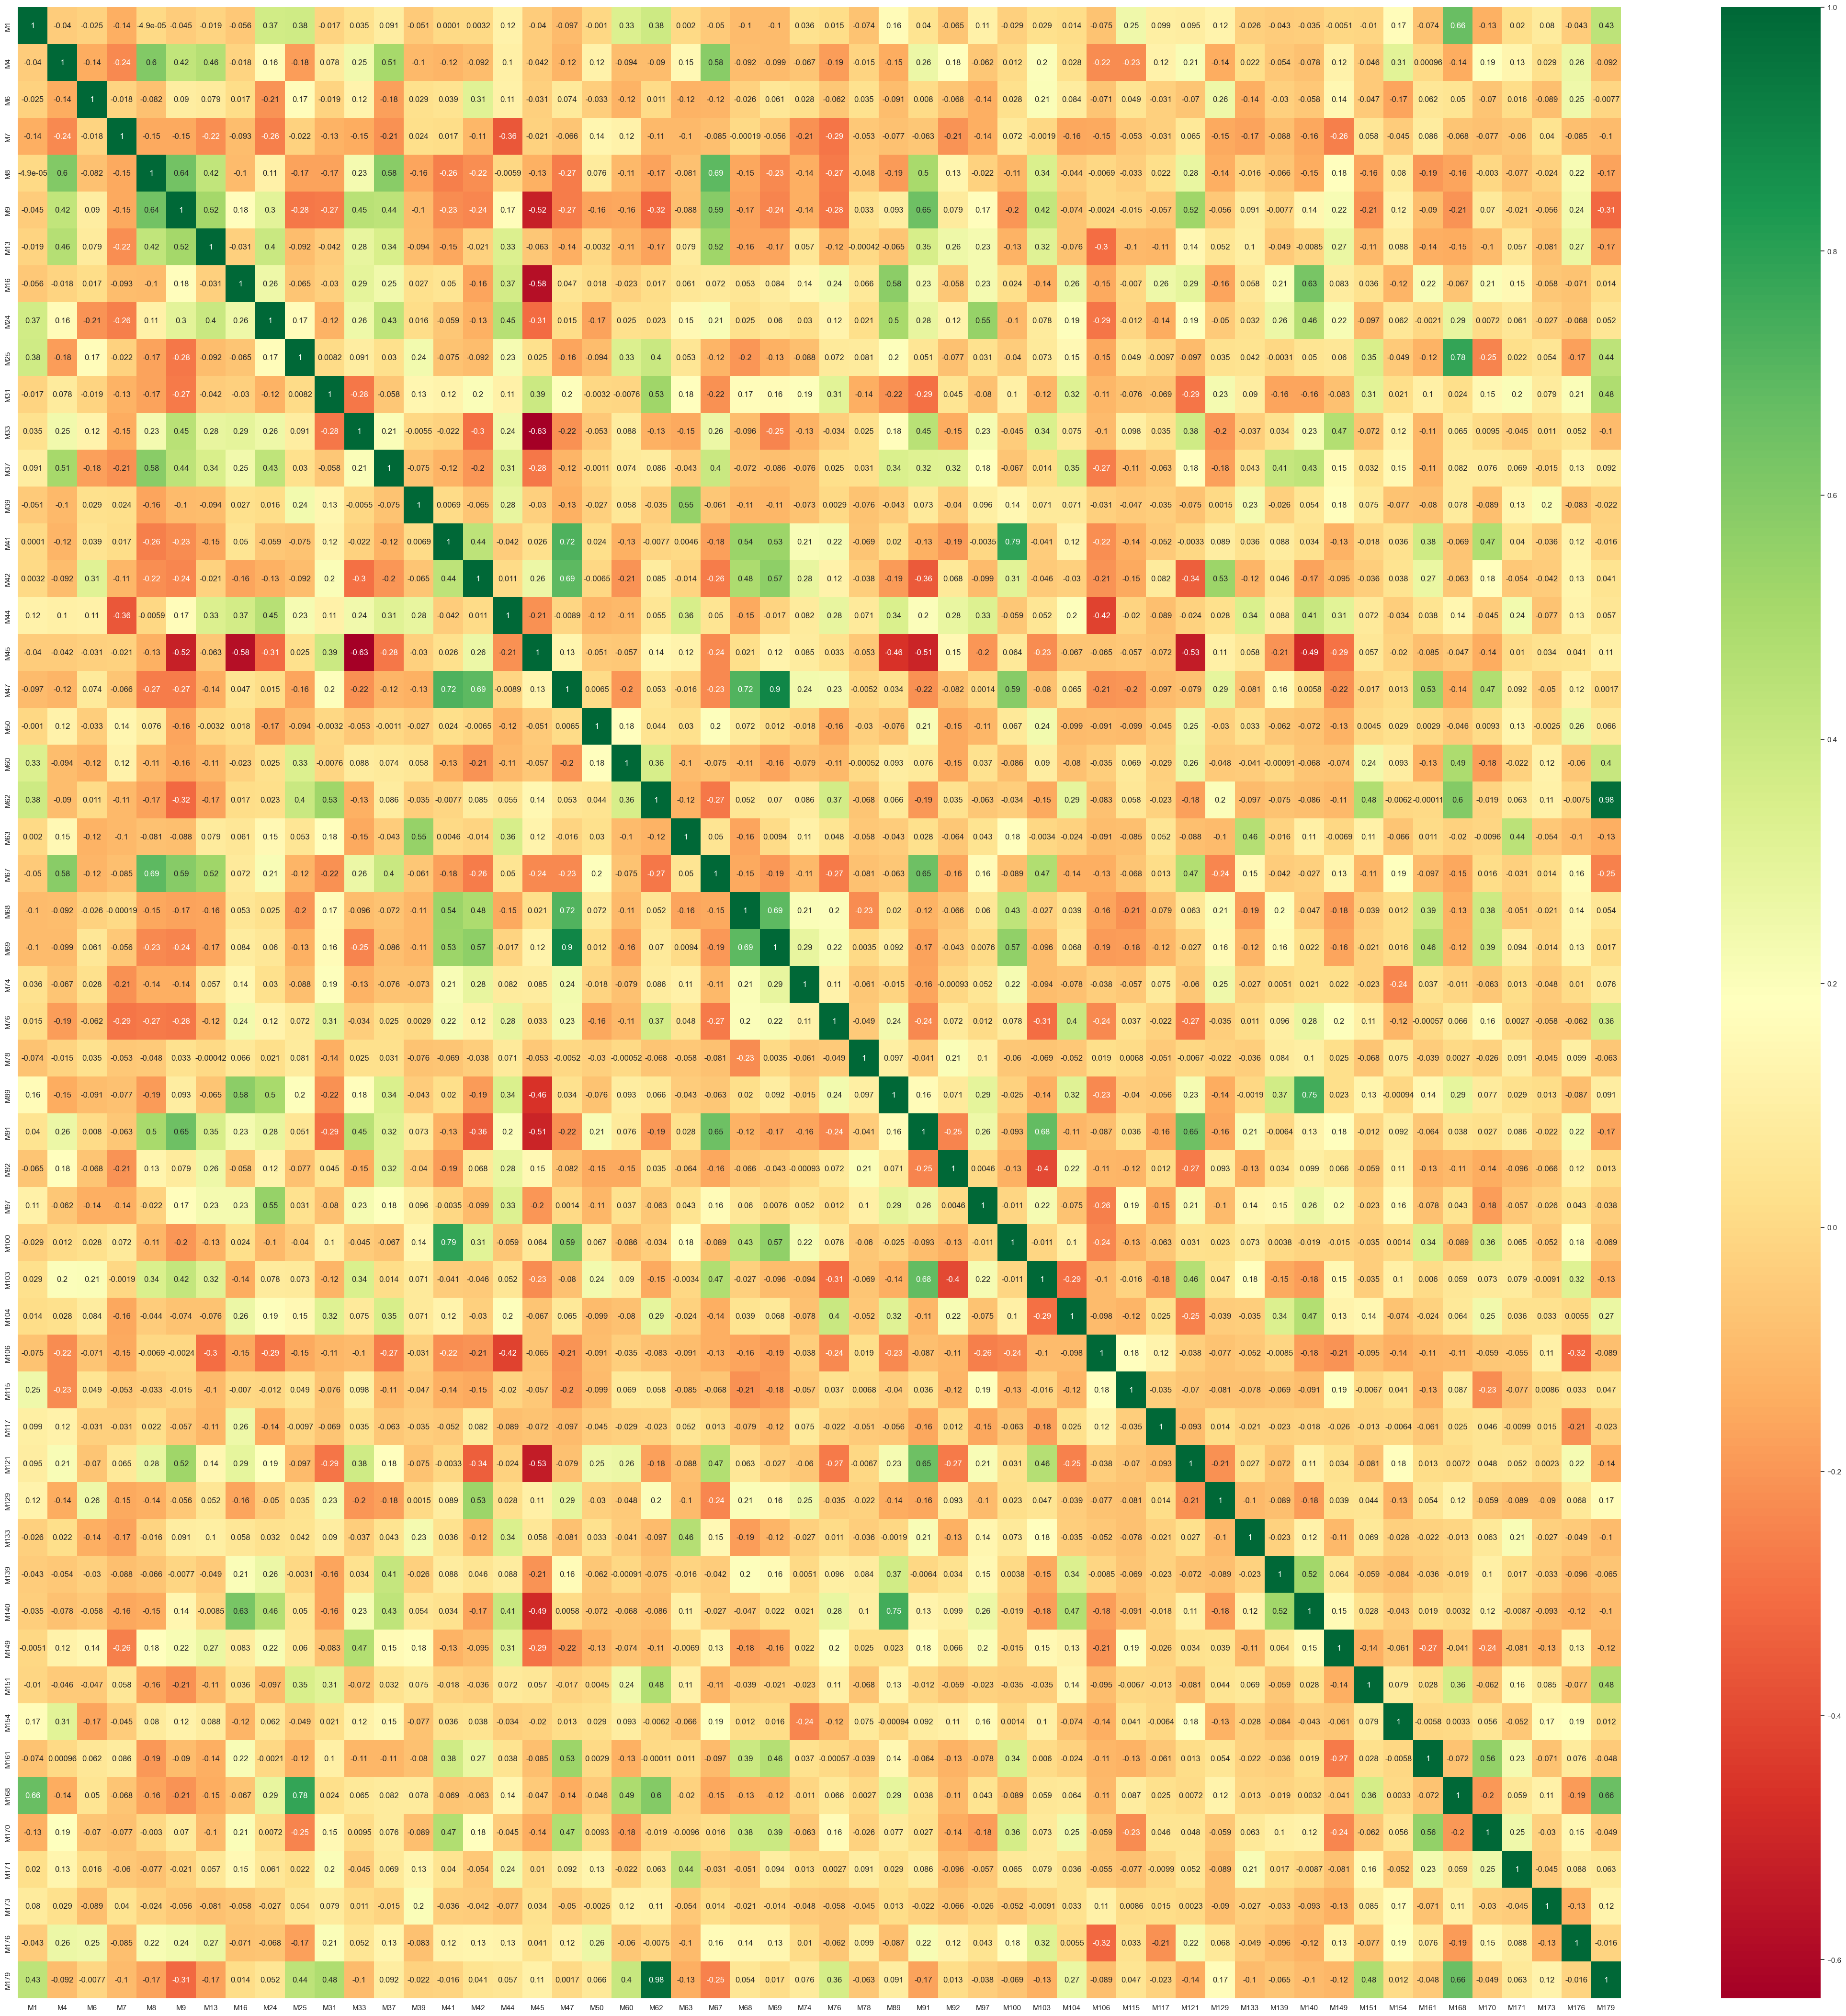

In [18]:
# Otteniamo le correlazioni tra le features
corrmat = X_top.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(k_fs, k_fs))

# Generiamo il grafico delle correlazioni
g=sns.heatmap(X_top[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### 8. PCA

In [19]:
pca = PCA()
pca.fit(X_knn)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.8) + 1
print("Numero di componenti principali:", d)

pca = PCA(n_components=d)
X_reduced = pca.fit_transform(X_knn)

Numero di componenti principali: 3


In [20]:
scores = cross_val_score(best_model, X_reduced, y, cv=kfolds, scoring='accuracy')
print(f'Accuratezza media: {scores.mean()}')

Accuratezza media: 0.6441176470588236


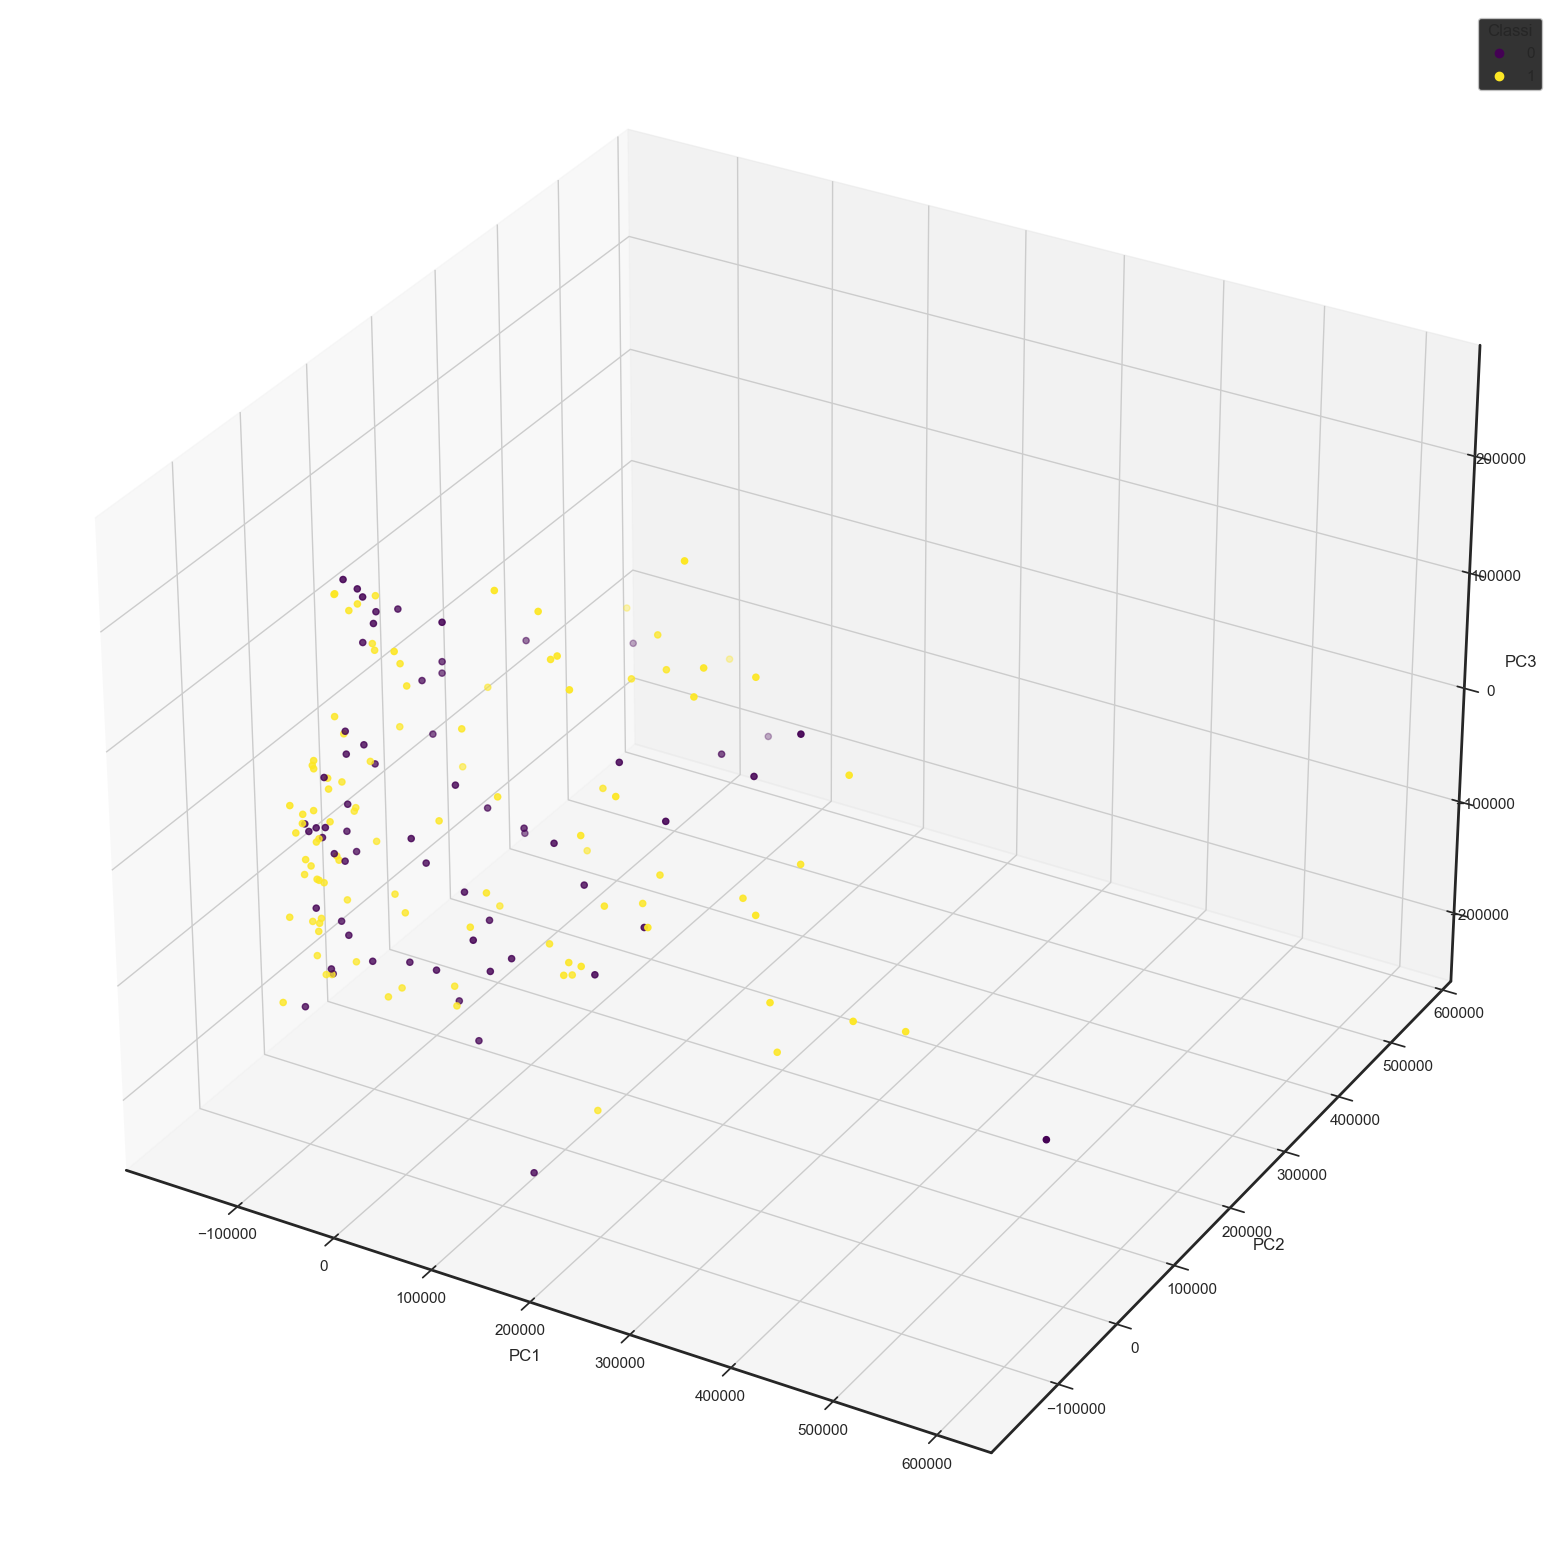

In [21]:
# Creazione di un grafico 3D
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# Plotting dei punti nel grafico 3D
scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, cmap='viridis')

# Aggiungi etichette agli assi
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Aggiungiamo una legenda per i colori
legend = ax.legend(*scatter.legend_elements(), title='Classi')

# Mostriamo il grafico
plt.show()


### 9. Results

Elenchiamo i risultati migliori: 

In [22]:
# Numero ottimale di fold
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

# Modello AdaBoost con gli iperparametri ottimizzati
model = AdaBoostClassifier(**best_params)

# K-Fold Cross Validation del modello con le features ottimali
y_pred = cross_val_predict(model, X_top, y, cv=kfolds, method='predict_proba')

# Scegliamo na soglia (threshold) per trasformare le probabilità in etichette binarie
threshold = 0.5
y_pred = (y_pred[:, 1] > threshold).astype(int)

# Calcoliamo le metriche
accuracy = metrics.accuracy_score(y, y_pred)
precision = metrics.precision_score(y, y_pred)
recall = metrics.recall_score(y, y_pred)
f1 = metrics.f1_score(y, y_pred)
roc_auc = metrics.roc_auc_score(y, y_pred)

In [23]:
# Stampiamo i risultati
print("------------------------")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

print("------------------------")
print(f'Matrice di confusione:\n {metrics.confusion_matrix(y, y_pred)}')
print("------------------------")
print(f'Migliori iperparametri:')
for h in best_params:
    print(f'- {h}: {best_params[h]}')
print("------------------------")
print(f'Features selezionate: {len(best_features)}')
print("------------------------")

------------------------
Accuracy: 0.8344
Precision: 0.8476
Recall: 0.8900
F1-score: 0.8683
ROC AUC: 0.8180
------------------------
Matrice di confusione:
 [[47 16]
 [11 89]]
------------------------
Migliori iperparametri:
- algorithm: SAMME.R
- estimator: None
- learning_rate: 1.0
- n_estimators: 300
- random_state: 42
------------------------
Features selezionate: 54
------------------------


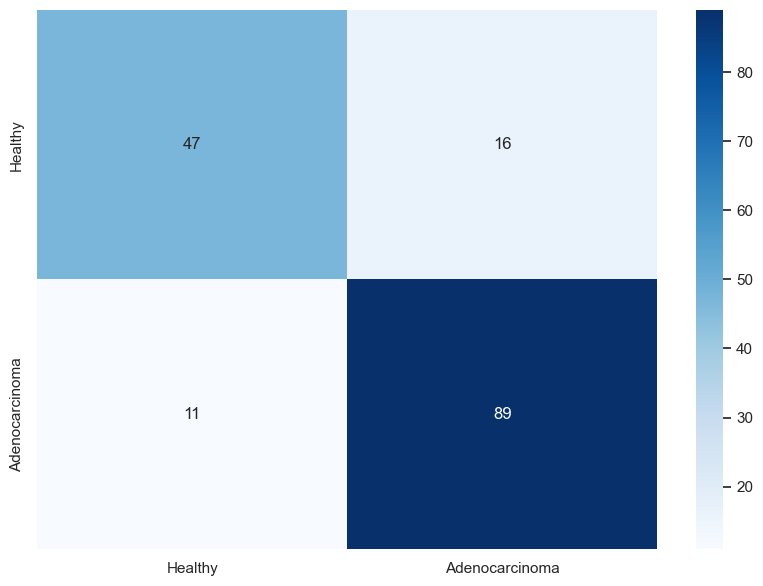

In [24]:
conf_mat = metrics.confusion_matrix(y, y_pred)
classes = ['Healthy', 'Adenocarcinoma']

df_cfm = pd.DataFrame(conf_mat, index=classes, columns=classes)
plt.figure(figsize=(10, 7))
cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues')
plt.show()


### 10. ROC Curve

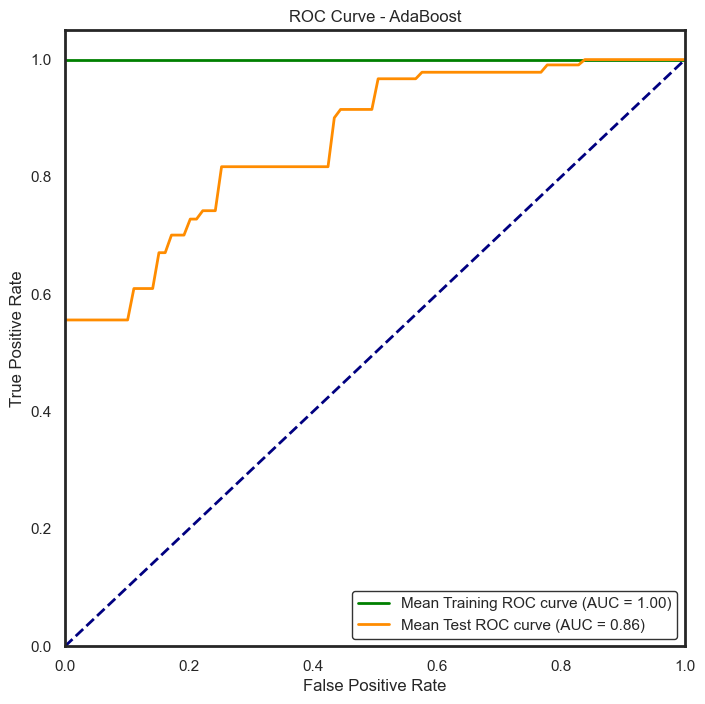

In [25]:
# Inizializziamo le liste per memorizzare i risultati dei singoli fold
all_fpr_train = []
all_tpr_train = []
all_fpr_test = []
all_tpr_test = []

# Eseguiamo la k-fold cross-validation
for train_idx, test_idx in kfolds.split(X_top, y):
    X_train, X_test = X_top.iloc[train_idx], X_top.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Addestriamo il modello sul training set
    model.fit(X_train, y_train)

    # Calcoliamo le probabilità di classe per i dati di training e test
    y_train_probs = model.predict_proba(X_train)[:, 1]
    y_test_probs = model.predict_proba(X_test)[:, 1]

    # Calcoliamo la curva ROC per i dati di training
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
    all_fpr_train.append(fpr_train)
    all_tpr_train.append(tpr_train)

    # Calcoliamo la curva ROC per i dati di test
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)
    all_fpr_test.append(fpr_test)
    all_tpr_test.append(tpr_test)

# Calcoliamo le curve ROC medie per i dati di training
mean_fpr_train = np.linspace(0, 1, 100)
mean_tpr_train = np.mean([np.interp(mean_fpr_train, fpr, tpr) for fpr, tpr in zip(all_fpr_train, all_tpr_train)], axis=0)
roc_auc_train = auc(mean_fpr_train, mean_tpr_train)

# Calcoliamo le curve ROC medie per i dati di test
mean_fpr_test = np.linspace(0, 1, 100)
mean_tpr_test = np.mean([np.interp(mean_fpr_test, fpr, tpr) for fpr, tpr in zip(all_fpr_test, all_tpr_test)], axis=0)
roc_auc_test = auc(mean_fpr_test, mean_tpr_test)

# Grafichiamo le curve ROC medie
plt.figure(figsize=(8, 8))
plt.plot(mean_fpr_train, mean_tpr_train, color='green', lw=2, label=f'Mean Training ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(mean_fpr_test, mean_tpr_test, color='darkorange', lw=2, label=f'Mean Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - AdaBoost')
plt.legend(loc="lower right", facecolor='white', edgecolor='black')
plt.show()